In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn 
import pickle
import re
import model.base
from model.base import Transformer
import utils 
from utils import MyDataset
import rdkit
from rdkit.Chem import rdDistGeom
import numpy as np
from torch.nn.utils import clip_grad_norm_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def subsequent_mask( size):
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )

    return subsequent_mask == 0


def get_mask(target, pad_value = -1) :
    mask = (target != torch.tensor(pad_value)).unsqueeze(-2)
    return mask & subsequent_mask(target.size(-1)).type_as(mask.data)

In [3]:
rdkit.rdBase.DisableLog('rdApp.*') # Disable rdkit warnings

In [4]:
dataset = MyDataset('data/chembl24_canon_train.pickle', 25)
train_set, val_set = random_split(dataset, [0.9, 0.1])
vocab = dataset.vocab

Error in embedding molecule:  Clc1ccc(C2CC3NCC32)cn1
Error in embedding molecule:  CC(=O)NC(=N)NCCC(=O)O
Error in embedding molecule:  Clc1ccc(C2CC3CNC32)cn1
Error in embedding molecule:  c1cc2ccc1CCc1ccc(cc1)CC2


In [8]:
train_loader = DataLoader(train_set, batch_size=128)
val_loader = DataLoader(val_set, batch_size=128)

In [9]:
model = Transformer(256, 512, 4, 4, 0.5, vocab).to(device)
loss_fn = nn.L1Loss()
optim = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [10]:
for i in range(20) : 
    train_loss, val_loss = 0, 0
    model.train()
    for src, x, y, z, tgt in train_loader : 
        src, x, y, z, tgt = src.to(device), x.to(device), y.to(device), z.to(device), tgt.to(device)
        src_mask = (src != vocab['<PAD>']).unsqueeze(-2) 
        x_mask = get_mask(x.squeeze(-1)[:, :-1])
        y_mask = get_mask(y.squeeze(-1)[:, :-1])
        z_mask = get_mask(z.squeeze(-1)[:, :-1])

        
        out = model(src, x[:, :-1], y[:, :-1], z[:, :-1], src_mask, x_mask, y_mask, z_mask)
        loss = loss_fn(out, tgt[:, 1:, :])
        train_loss += loss.item() 
        loss.backward(), optim.step(), optim.zero_grad(), clip_grad_norm_(model.parameters(), 5)

    model.eval()
    for src, x, y, z, tgt in train_loader : 
        src, x, y, z, tgt = src.to(device), x.to(device), y.to(device), z.to(device), tgt.to(device)
        src_mask = (src != vocab['<PAD>']).unsqueeze(-2) 
        x_mask = get_mask(x.squeeze(-1)[:, :-1])
        y_mask = get_mask(y.squeeze(-1)[:, :-1])
        z_mask = get_mask(z.squeeze(-1)[:, :-1])

        
        out = model(src, x[:, :-1], y[:, :-1], z[:, :-1], src_mask, x_mask, y_mask, z_mask)
        loss = loss_fn(out, tgt[:, 1:, :])
        val_loss += loss.item() 
    print(f'Epoch {i+1} - Train Loss: {train_loss / len(train_loader):.3f} - Val Loss: {val_loss / len(val_loader):.3f}')

In [141]:
a = model.ydecoder.layers[0].src_attn.attn[0] 
a = a.cpu().data.numpy()
b = model.encoder.layers[0].self_attn.attn[3]
b = b.cpu().data.numpy()

In [142]:
import matplotlib.pyplot as plt 

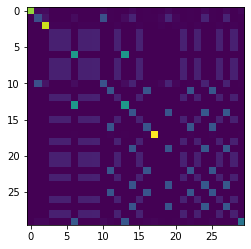

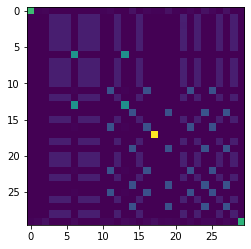

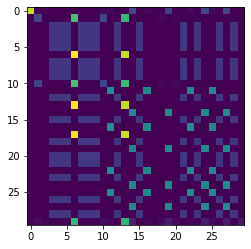

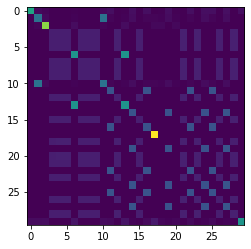

In [143]:
for head in b : 
    plt.imshow(head) 
    plt.show()

In [7]:
a = [1,2,3,4, None, 5, 6,7,8, None]
# b = [x for i, x in enumerate(a) if x is not None else a[i-1]]
b = [x if x is not None else a[i-1] for i, x in enumerate(a)]
b

[1, 2, 3, 4, 4, 5, 6, 7, 8, 8]